In [33]:
import numpy as np
import shapely
import geopandas as gpd
import pandas as pd
import fiona # https://www.lfd.uci.edu/~gohlke/pythonlibs/#gdal, https://www.lfd.uci.edu/~gohlke/pythonlibs/#fiona, pip install shapely, pip install geopandas,, 
import matplotlib.pyplot as plt

In [34]:
pa_bg = gpd.read_file('pa_cbg_shapefile')
voting_pop = pd.read_csv("pa_cbg_pop/pop.csv")
voting_pop['GEOID'] = voting_pop['GEO_ID'].apply(lambda x: x.split("US")[1])
pa_bg = pa_bg.merge(voting_pop, on="GEOID")

pa_bg.to_crs("EPSG:2271")
pa_bg['REPRESENTATIVE_POINT'] =  pa_bg.representative_point() # https://gis.stackexchange.com/a/414263

total_pop = pa_bg['Population'].sum()

print(pa_bg.shape)
pa_bg.sample(n=5)

(10173, 17)


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,GEO_ID,NAME,Population,REPRESENTATIVE_POINT
5845,42,101,030000,4,421010300004,Block Group 4,G5030,S,275129,0,+40.0151309,-075.0818346,"POLYGON ((-75.08553 40.01617, -75.08473 40.017...",1500000US421010300004,"Block Group 4, Census Tract 300, Philadelphia ...",1387,POINT (-75.08175 40.01507)
2748,42,015,950501,2,420159505012,Block Group 2,G5030,S,1333127,0,+41.9840477,-076.5393528,"POLYGON ((-76.54774 41.99132, -76.54739 41.991...",1500000US420159505012,"Block Group 2, Census Tract 9505.01, Bradford ...",1019,POINT (-76.53930 41.98396)
6902,42,003,030500,2,420030305002,Block Group 2,G5030,S,280636,0,+40.4403910,-079.9813877,"POLYGON ((-79.98601 40.44103, -79.98590 40.441...",1500000US420030305002,"Block Group 2, Census Tract 305, Allegheny Cou...",853,POINT (-79.98240 40.44105)
1617,42,101,016400,2,421010164002,Block Group 2,G5030,S,53675,0,+39.9873915,-075.1402732,"POLYGON ((-75.14120 39.98752, -75.14086 39.989...",1500000US421010164002,"Block Group 2, Census Tract 164, Philadelphia ...",428,POINT (-75.14027 39.98740)
3429,42,101,037600,3,421010376003,Block Group 3,G5030,S,209087,0,+39.9589628,-075.1586003,"POLYGON ((-75.16232 39.95793, -75.16229 39.958...",1500000US421010376003,"Block Group 3, Census Tract 376, Philadelphia ...",1465,POINT (-75.15860 39.95896)


In [35]:
def splits_to_regions_binary(row, splits):
    num = 0
    for v in splits:
        num = 2 * num + row[v]
    return num


In [36]:
pa_bg['RP_LON'] = pa_bg['REPRESENTATIVE_POINT'].apply(lambda p: p.x)
pa_bg['RP_LAT'] = pa_bg['REPRESENTATIVE_POINT'].apply(lambda p: p.y)

pop_center_LON = (pa_bg['RP_LON'] * pa_bg['Population']).sum()/pa_bg['Population'].sum()
pop_center_LAT =  (pa_bg['RP_LAT'] * pa_bg['Population']).sum()/pa_bg['Population'].sum()

In [37]:
df = pd.DataFrame({
    "Name": ["Original Population Center"],
    "Step": [0],
    "Latitude": [pop_center_LAT],
    "Longitude": [pop_center_LON]
})
new_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

In [38]:
pa_bg['RECENTERED_LON'] = pa_bg['RP_LON'] - pop_center_LON
pa_bg['RECENTERED_LAT'] = pa_bg['RP_LAT'] - pop_center_LAT

pa_bg['RECENTERED_RATIO'] = pa_bg['RECENTERED_LAT']/pa_bg['RECENTERED_LON']
pa_bg['RECENTERED_ANGLE'] = np.degrees(np.arctan2(pa_bg['RECENTERED_LAT'], pa_bg['RECENTERED_LON']))
pa_bg['RECENTERED_ANGLE'] = pa_bg['RECENTERED_ANGLE'].apply(lambda x: x if x > 0 else x + 360)

pa_bg = pa_bg.sort_values('RECENTERED_ANGLE')

In [47]:
pa_bg.sample(5)

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,Population,REPRESENTATIVE_POINT,RP_LON,RP_LAT,RECENTERED_LON,RECENTERED_LAT,RECENTERED_RATIO,RECENTERED_ANGLE,RESETTED_ANGLE,SPLIT_1
3102,42,075,003200,1,420750032001,Block Group 1,G5030,S,16691618,91078,...,2112,POINT (-76.36435 40.32640),-76.364354,40.326396,0.625341,-0.120559,-0.192789,349.087902,344.087902,0
9520,42,101,032000,3,421010320003,Block Group 3,G5030,S,90658,0,...,770,POINT (-75.05651 40.02803),-75.056512,40.028026,1.933184,-0.418928,-0.216704,347.772847,342.772847,0
8383,42,041,011304,2,420410113042,Block Group 2,G5030,S,1559398,137472,...,1651,POINT (-76.94756 40.24694),-76.947563,40.246938,0.042132,-0.200017,-4.747395,281.894995,276.894995,0
1696,42,091,207201,2,420912072012,Block Group 2,G5030,S,316937,0,...,569,POINT (-75.32614 40.30613),-75.326137,40.306135,1.663558,-0.140820,-0.084650,355.161463,350.161463,0
9757,42,077,006102,1,420770061021,Block Group 1,G5030,S,345260,0,...,683,POINT (-75.51366 40.61189),-75.513657,40.611891,1.476039,0.164936,0.111742,6.375906,1.375906,1


In [40]:
%%time
ranges = []
total_pop = pa_bg['Population'].sum()
for d in np.linspace(0, 359, 360):
    pa_bg['RESETTED_ANGLE'] = pa_bg['RECENTERED_ANGLE'] - d
    pa_bg['RESETTED_ANGLE'] = pa_bg['RESETTED_ANGLE'].apply(lambda x: x if x > 0 else (x + (360-d)))
    pa_bg = pa_bg.sort_values('RESETTED_ANGLE')
    pa_bg.reset_index(drop=True)
    
    i = 0
    captured_pop = 0
    while captured_pop < 0.5*total_pop:
        captured_pop += pa_bg.loc[i, 'Population']
        i += 1
    final_angle = pa_bg.iloc[i-1]['RESETTED_ANGLE']
    
    ranges.append((d, final_angle))

    if d == 5:
        break
    

Wall time: 636 ms


In [42]:
this_range = ranges[0]
# this_range = (0,90)
split = 1
pa_bg[f'SPLIT_{split}'] = pa_bg['RECENTERED_ANGLE'].apply(lambda x: 1 if this_range[0] <= x <= this_range[1] else 0 )

<Figure size 576x576 with 0 Axes>

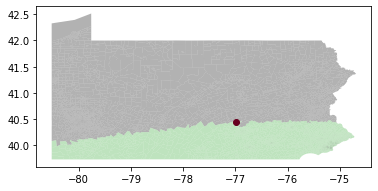

In [43]:
plt.figure(figsize=(8,8))
base = pa_bg.plot(column="SPLIT_1", cmap="Accent", alpha = 0.5)
new_gdf.plot(ax=base, column="Step", cmap="RdBu")
plt.show()

In [44]:
district_0 = pa_bg.loc[pa_bg[f'SPLIT_{split}'] == 0].copy()
district_1 = pa_bg.loc[pa_bg[f'SPLIT_{split}'] == 1].copy()

d_0_pop_center_LON = (district_0['RP_LON'] * district_0['Population']).sum()/district_0['Population'].sum()
d_1_pop_center_LON = (district_1['RP_LON'] * district_1['Population']).sum()/district_1['Population'].sum()

d_0_pop_center_LAT =  (district_0['RP_LAT'] * district_0['Population']).sum()/district_0['Population'].sum()
d_1_pop_center_LAT =  (district_1['RP_LAT'] * district_1['Population']).sum()/district_1['Population'].sum()

In [45]:
split = 2

In [48]:
district_0['RECENTERED_LON'] = district_0['RP_LON'] - d_0_pop_center_LON
district_0['RECENTERED_LAT'] = district_0['RP_LAT'] - d_1_pop_center_LAT

district_0['RECENTERED_RATIO'] = district_0['RECENTERED_LAT']/district_0['RECENTERED_LON']
district_0['RECENTERED_ANGLE'] = np.degrees(np.arctan2(district_0['RECENTERED_LAT'], district_0['RECENTERED_LON']))
district_0['RECENTERED_ANGLE'] = district_0['RECENTERED_ANGLE'].apply(lambda x: x if x > 0 else x + 360)
district_0 = district_0.sort_values('RECENTERED_ANGLE').reset_index(drop=True)

# FOR RIGHT NOW ONLY 0 START
d = 0
district_0['RESETTED_ANGLE'] = district_0['RECENTERED_ANGLE'] - d
district_0['RESETTED_ANGLE'] = district_0['RESETTED_ANGLE'].apply(lambda x: x if x > 0 else (x + (360-d)))
district_0 = district_0.sort_values('RESETTED_ANGLE').reset_index(drop=True)

total_pop = district_0['Population'].sum()

i = 0
captured_pop = 0
while captured_pop < 0.5*total_pop:
    captured_pop += district_0.loc[i, 'Population']
    i += 1
final_angle = district_0.loc[i-1, 'RECENTERED_ANGLE']

district_0[f'SPLIT_{split}'] = district_0['RECENTERED_ANGLE'].apply(lambda x: 1 if d <= x <= final_angle else 0)


In [54]:
district_1['RECENTERED_LON'] = district_1['RP_LON'] - d_1_pop_center_LON
district_1['RECENTERED_LAT'] = district_1['RP_LAT'] - d_1_pop_center_LAT

district_1['RECENTERED_RATIO'] = district_1['RECENTERED_LAT']/district_1['RECENTERED_LON']
district_1['RECENTERED_ANGLE'] = np.degrees(np.arctan2(district_1['RECENTERED_LAT'], district_1['RECENTERED_LON']))
district_1['RECENTERED_ANGLE'] = district_1['RECENTERED_ANGLE'].apply(lambda x: x if x > 0 else x + 360)
district_1 = district_1.sort_values('RECENTERED_ANGLE').reset_index(drop=True)

# FOR RIGHT NOW ONLY 0 START
d = 0
district_1['RESETTED_ANGLE'] = district_1['RECENTERED_ANGLE'] - d
district_1['RESETTED_ANGLE'] = district_1['RESETTED_ANGLE'].apply(lambda x: x if x > 0 else (x + (360-d)))
district_1 = district_1.sort_values('RESETTED_ANGLE').reset_index(drop=True)

total_pop = district_1['Population'].sum()

i = 0
captured_pop = 0
while captured_pop < 0.5*total_pop:
    captured_pop += district_1.loc[i, 'Population']
    i += 1
final_angle = district_1.loc[i-1, 'RECENTERED_ANGLE']

district_1[f'SPLIT_{split}'] = district_1['RECENTERED_ANGLE'].apply(lambda x: 1 if d <= x <= final_angle else 0)

In [55]:
f'SPLIT_{split}'

'SPLIT_2'

In [56]:
def splits_to_regions_binary(row, splits):
    num = 0
    for v in splits:
        num = 2 * num + row[v]
    return num

<Figure size 576x576 with 0 Axes>

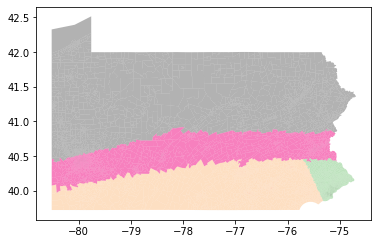

In [57]:
all_districts = pd.concat([district_0, district_1])
all_districts['STEP_2'] = all_districts.apply(splits_to_regions_binary, splits = ['SPLIT_1', 'SPLIT_2'], axis = 1)

plt.figure(figsize=(8,8))
base = all_districts.plot(column="STEP_2", cmap="Accent", alpha = 0.5)
plt.show()

In [58]:
all_districts

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,RP_LON,RP_LAT,RECENTERED_LON,RECENTERED_LAT,RECENTERED_RATIO,RECENTERED_ANGLE,RESETTED_ANGLE,SPLIT_1,SPLIT_2,STEP_2
0,42,125,796000,2,421257960002,Block Group 2,G5030,S,101320668,0,...,-80.473546,40.021419,-4.555493,-0.827178,0.181578,190.291532,190.291532,0,1,1
1,42,125,796000,3,421257960003,Block Group 3,G5030,S,73601599,27377,...,-80.290403,40.037061,-4.372351,-0.811536,0.185606,190.514805,190.514805,0,1,1
2,42,125,763700,1,421257637001,Block Group 1,G5030,S,30605206,0,...,-79.996747,40.084261,-4.078694,-0.764335,0.187397,190.613959,190.613959,0,1,1
3,42,125,791000,2,421257910002,Block Group 2,G5030,S,8985930,208912,...,-79.881195,40.095291,-3.963143,-0.753306,0.190078,190.762284,190.762284,0,1,1
4,42,125,784000,2,421257840002,Block Group 2,G5030,S,6754471,363576,...,-79.851064,40.100613,-3.933011,-0.747983,0.190181,190.767967,190.767967,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5150,42,095,015300,2,420950153002,Block Group 2,G5030,S,24226360,225307,...,-75.171458,40.842968,2.978999,-0.005629,-0.001890,359.891728,359.891728,1,0,2
5151,42,095,015500,3,420950155003,Block Group 3,G5030,S,13319262,128624,...,-75.269939,40.843322,2.880519,-0.005275,-0.001831,359.895077,359.895077,1,0,2
5152,42,097,080800,1,420970808001,Block Group 1,G5030,S,30005413,88706,...,-76.552555,40.845974,1.597903,-0.002622,-0.001641,359.905968,359.905968,1,0,2
5153,42,107,000100,3,421070001003,Block Group 3,G5030,S,55802804,415672,...,-76.239971,40.845746,1.910486,-0.002851,-0.001492,359.914500,359.914500,1,0,2


In [163]:
inpt = 5

# WIP: Recursive Splitting

def split_districts(total_districts, df=None, split=1):
    
    print(total_districts)
    pop_center_LON = (df['RP_LON'] * df['Population']).sum()/df['Population'].sum()
    pop_center_LAT =  (df['RP_LAT'] * df['Population']).sum()/df['Population'].sum()
    
    df['RECENTERED_LON'] = df['RP_LON'] - pop_center_LON
    df['RECENTERED_LAT'] = df['RP_LAT'] - pop_center_LAT
    
    df['RECENTERED_RATIO'] = df['RECENTERED_LAT']/df['RECENTERED_LON']
    df['RECENTERED_ANGLE'] = np.degrees(np.arctan2(df['RECENTERED_LAT'], df['RECENTERED_LON'])) + 180

    df = df.sort_values('RECENTERED_ANGLE').reset_index(drop=True)
    
    # FOR RIGHT NOW ONLY 0 START
    d = 0
    df['RESETTED_ANGLE'] = df['RECENTERED_ANGLE'] - d
    df['RESETTED_ANGLE'] = df['RESETTED_ANGLE'].apply(lambda x: x if x > 0 else (x + (360-d)))
    df = df.sort_values('RESETTED_ANGLE').reset_index(drop=True)
    
    i = 0
    captured_pop = 0
    while captured_pop < 0.5*total_pop:
        captured_pop += df.loc[i, 'Population']
        i += 1
    final_angle = df.loc[i-1, 'RECENTERED_ANGLE']
    
    df[f'SPLIT_{split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if d <= x <= final_angle else 0)
    
    
    if total_districts != 1:
        if total_districts % 2 == 0:
            districts_a = int(total_districts/2)
            districts_b = districts_a
            split_districts(districts_a, df, split=split+1)
            split_districts(districts_b, df, split=split+1)
        else:
            districts_a = int(total_districts/2)
            districts_b = districts_a + 1
            split_districts(districts_a, df, split=split+1)
            split_districts(districts_b, df, split=split+1)
    else:
        return df    
    
split_districts(5, pa_bg)

5


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,Population,REPRESENTATIVE_POINT,RP_LON,RP_LAT,RECENTERED_LON,RECENTERED_LAT,RECENTERED_RATIO,RECENTERED_ANGLE,RESETTED_ANGLE,SPLIT_1
0,42,003,453004,2,420034530042,Block Group 2,G5030,S,1196327,0,...,1650,POINT (-80.21406 40.44674),-80.214058,40.446743,-3.224363,-0.000212,0.000066,0.003762,0.003762,1
1,42,003,981200,1,420039812001,Block Group 1,G5030,S,461252,135771,...,0,POINT (-80.01052 40.44652),-80.010520,40.446516,-3.020825,-0.000439,0.000145,0.008331,0.008331,1
2,42,003,281400,2,420032814002,Block Group 2,G5030,S,980859,0,...,1090,POINT (-80.05232 40.44633),-80.052323,40.446332,-3.062628,-0.000622,0.000203,0.011641,0.011641,1
3,42,003,464300,2,420034643002,Block Group 2,G5030,S,395349,0,...,874,POINT (-80.06828 40.44612),-80.068283,40.446123,-3.078587,-0.000832,0.000270,0.015479,0.015479,1
4,42,003,050100,1,420030501001,Block Group 1,G5030,S,308316,0,...,706,POINT (-79.97820 40.44611),-79.978201,40.446115,-2.988505,-0.000840,0.000281,0.016109,0.016109,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10168,42,003,562600,2,420035626002,Block Group 2,G5030,S,1010425,187348,...,941,POINT (-80.03670 40.44756),-80.036704,40.447564,-3.047008,0.000609,-0.000200,359.988543,359.988543,0
10169,42,013,011002,1,420130110021,Block Group 1,G5030,S,8734310,0,...,1723,POINT (-78.41081 40.44720),-78.410809,40.447203,-1.421114,0.000248,-0.000175,359.989990,359.989990,0
10170,42,003,140400,2,420031404002,Block Group 2,G5030,S,199425,0,...,508,POINT (-79.91384 40.44736),-79.913836,40.447357,-2.924140,0.000402,-0.000138,359.992118,359.992118,0
10171,42,003,521500,2,420035215002,Block Group 2,G5030,S,4392200,0,...,1564,POINT (-79.74234 40.44730),-79.742338,40.447303,-2.752643,0.000348,-0.000127,359.992751,359.992751,0


In [133]:
split_regions(1, 9)

(4, 5)

In [ ]:
region_0 = pa_bg.loc[pa_bg['SPLIT1'] == 0].copy()
region_1 = pa_bg.loc[pa_bg['SPLIT1'] == 1].copy()

r_0_pop_center_LON = (region_0['RP_LON'] * region_0['Population']).sum()/region_0['Population'].sum()
r_1_pop_center_LON = (region_1['RP_LON'] * region_1['Population']).sum()/region_1['Population'].sum()

r_0_pop_center_LAT =  (region_0['RP_LAT'] * region_0['Population']).sum()/region_0['Population'].sum()
r_1_pop_center_LAT =  (region_1['RP_LAT'] * region_1['Population']).sum()/region_1['Population'].sum()